Шаг 1: Загрузка данных


In [ ]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List
import re
import string

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

In [ ]:
users = pd.read_csv('Users.csv', on_bad_lines='skip', sep=";", encoding="ISO-8859-1", low_memory=False)
books = pd.read_csv('Books.csv', on_bad_lines='skip', sep=";", encoding="ISO-8859-1")
ratings = pd.read_csv('Book_ratings.csv', on_bad_lines='skip', sep=';', encoding='ISO-8859-1')

<ipython-input-2-64a1c95e9d92>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('Books.csv', on_bad_lines='skip', sep=";", encoding="ISO-8859-1")


Шаг 2: Подготовка данных


In [ ]:
books.drop(['Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)
books.columns = ['book_id', 'name', 'author']

ratings.columns = ['user_id', 'book_id', 'rating']

In [ ]:
ratings = ratings.query('rating > 6')
book_count = ratings.groupby('user_id')['book_id'].count().reset_index(name='book_count')
filtered_users = book_count[book_count['book_count'] >= 150]
filtered_ratings = pd.merge(filtered_users, ratings, on='user_id')

In [ ]:
filtered_ratings.drop(['book_count', 'rating'], axis=1, inplace=True)
ratings = filtered_ratings

In [ ]:
books

,book_id,name,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber
...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger
271356,0525447644,From One to One Hundred,Teri Sloat
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker
271358,0192126040,Republic (World's Classics),Plato


Расчет метрики

In [ ]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 5):
    map_k, count = 0, 0
    for relevant_items, predicted_items in  zip(relevant, predicted):
        if not relevant_items:
            continue
        correct = np.isin(predicted_items[:k], relevant_items)
        p_k = np.cumsum(correct) / np.arange(1, k + 1)
        ap_k = np.dot(p_k, correct) / np.minimum(k, len(relevant_items))
        map_k += ap_k
        count += 1

    map_k = map_k / count
    return map_k

Разделим выборку на тестовую и трейновую, чтобы в тестовый датасет попали 30 последних книг каждого пользователя.

In [ ]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 30

    # getting train samples
    for user_id, user_data in tqdm(ratings.groupby('user_id')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['book_id'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for user_id, user_data in tqdm(ratings.groupby('user_id')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['book_id'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [ ]:
from sklearn.utils import shuffle
ratings = shuffle(ratings)

In [ ]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

Почистим табличку с информацией о книгах и закодируем id книг так, чтобы они соответствовали их порядковому номеру.

In [ ]:
redundant_rows = np.where(~np.isin(books['book_id'], train_ratings['book_id'].unique()))[0]
books.drop(redundant_rows, inplace=True)
books = books.reset_index(drop=True)

In [ ]:
items = sorted(train_ratings['book_id'].unique())
iencoder = LabelEncoder()
iencoder.fit(items)

LabelEncoder()

In [ ]:
train_ratings['book_id'] = iencoder.transform(train_ratings['book_id'].tolist())
test_ratings['book_id'] = iencoder.transform(test_ratings['book_id'].tolist())
books['book_id'] = iencoder.transform(books['book_id'].tolist())

In [ ]:
users = sorted(train_ratings['user_id'].unique())
uencoder = LabelEncoder()
uencoder.fit(users)

LabelEncoder()

In [ ]:
train_ratings['user_id'] = uencoder.transform(train_ratings['user_id'].tolist())
test_ratings['user_id'] = uencoder.transform(test_ratings['user_id'].tolist())

In [ ]:
train_ratings

,user_id,book_id
0,0,18314
1,0,15697
2,0,31607
3,0,7883
4,0,24395
...,...,...
53629,163,6599
53630,163,21851
53631,163,27532
53632,163,8532


In [ ]:
test_ratings

,user_id,book_id
0,0,14542
1,0,1934
2,0,22057
3,0,21207
4,0,27747
...,...,...
1836,163,17405
1837,163,21416
1838,163,21992
1839,163,23709


Соберем все релевантные книги для каждого пользователя в список.

In [ ]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('user_id'):
    test_relevant += [user_data['book_id'].tolist()]
    test_users.append(user_id)

Реализуем метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих книг для каждого пользователя. Удалим уже прочитанные книги из рекомендуемых.

In [ ]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['user_id']))
        self.n_items = len(np.unique(self.ratings['book_id']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['user_id'], self.ratings['book_id']] = 1.

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('user_id'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['book_id'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        for uid in range(self.n_users):
            test_preds.append(self.recommend(uid))

        test_preds = self.remove_train_items(test_preds, k)
        return test_preds[test_users]

Рандомная рекомендация

In [ ]:
class Random(BaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)

    def recommend(self, uid: int):
        books_indexes = self.ratings['book_id'].unique()
        pred = np.random.choice(books_indexes, 50)
        return pred

# Пользовательская коллаборативная фильтрация


Функции подсчета корреляции Пирмона и меры Жаккара

In [ ]:
def pearson(ratings: np.array, user_vector: np.array) -> np.array:
    ratings_sum = np.sum(ratings, axis = 1)
    users_sum = np.sum(user_vector)
    return (ratings @ user_vector.T) / (np.sqrt(ratings_sum) * np.sqrt(users_sum))


def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    intersection = ratings @ user_vector
    union = np.sum(ratings, axis = 1) + np.sum(user_vector) - intersection
    return intersection / union

Реализуем методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.

In [ ]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        similarity = self.similarity(self.R[uid, :])
        mask = similarity < self.alpha
        similarity[mask] = 0
        pred_rating = (self.R.T @ similarity) / similarity.sum()
        return np.argsort(pred_rating)[::-1]

 Построем графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравним их между собой, а также с предсказаниями случайного алгоритма.

In [ ]:
ks = np.arange(1, 31, 3)
infou2u = pd.DataFrame(columns=['k', 'random_score', 'pearson_score', 'jaccard_score'])

In [ ]:
model_random = Random(train_ratings)
model_pearson = User2User(train_ratings, pearson)
model_jaccard = User2User(train_ratings, jaccard)

for k in ks:
    random_recommend = model_random.get_test_recommendations(k)
    random_score = mapk(test_relevant, random_recommend, k)
    pearson_recommend = model_pearson.get_test_recommendations(k)
    pearson_score = mapk(test_relevant, pearson_recommend, k)
    jaccard_recommend = model_jaccard.get_test_recommendations(k)
    jaccard_score = mapk(test_relevant, jaccard_recommend, k)

    new_row = {'k':k, 'random_score':random_score, 'pearson_score':pearson_score, 'jaccard_score':jaccard_score}
    infou2u = infou2u.append(new_row, ignore_index=True)

<ipython-input-24-26a2b446dc71>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infou2u = infou2u.append(new_row, ignore_index=True)
<ipython-input-24-26a2b446dc71>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infou2u = infou2u.append(new_row, ignore_index=True)
<ipython-input-24-26a2b446dc71>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infou2u = infou2u.append(new_row, ignore_index=True)
<ipython-input-24-26a2b446dc71>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infou2u = infou2u.append(new_row, ignore_index=True)
<ipython-input-24-26a2b446dc71>:14: FutureWarning: The frame.append method is deprecated and will be rem

In [ ]:
infou2u

,k,random_score,pearson_score,jaccard_score
0,1.0,0.000000,0.068323,0.043478
1,4.0,0.000000,0.029891,0.022516
2,7.0,0.000000,0.020875,0.016069
3,10.0,0.000000,0.016466,0.011968
4,13.0,0.000062,0.014353,0.009732
5,16.0,0.000222,0.013319,0.008712
6,19.0,0.000000,0.013006,0.008095
7,22.0,0.000086,0.012614,0.007890
8,25.0,0.000000,0.012930,0.007951
9,28.0,0.000205,0.013196,0.008118


Text(0, 0.5, 'MAP@K score')

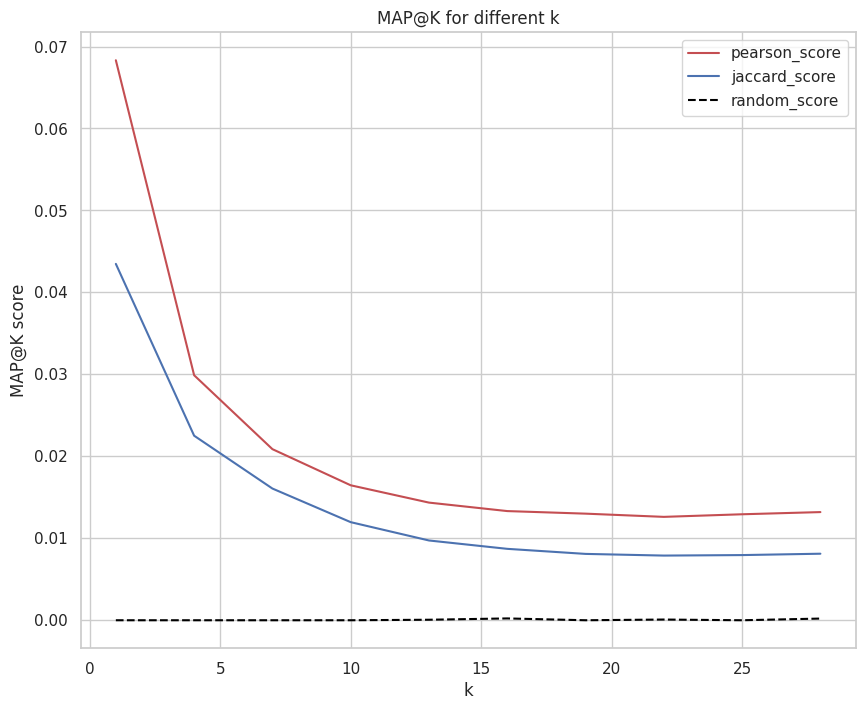

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
infou2u.plot(x='k', y='pearson_score', ax=ax, color='r')
infou2u.plot(x='k', y='jaccard_score', ax=ax, color='b')
infou2u.plot(x='k', y='random_score', ax=ax, color='black', linestyle='dashed')

ax.set_title("MAP@K for different k")
ax.set_xlabel('k')
ax.set_ylabel('MAP@K score')

In [ ]:
user_id = 111

In [ ]:
books_read = train_ratings[train_ratings.user_id == user_id].book_id[:15]

print('Already read books:')

books.loc[books_read][['name', 'author']]

Already read books:


,name,author
10198,The Wedding Diaries,LINDA FRANCIS LEE
17038,The Sound and the Fury: An Authoritative Text ...,William Faulkner
9947,Coming of Age in Mississippi,Anne Moody
9920,Love You to Death (Stonewall Inn Mystery),Grant Michaels
23762,Linden Hills (Contemporary American Fiction Se...,Gloria Naylor
9564,Tek Secret,William Shatner
9341,Dark Obsession (Reader's Choice Dreamscapes),Mark Stevens
12125,My Lover's Lover,Maggie O'Farrell
12157,The Observer's Book of Music (Observer's Pocke...,Freda Dinn
10342,Voll im Bilde. Ein Roman von der bizarren Sche...,Terry Pratchett


In [ ]:
preds = model_pearson.get_test_recommendations(15)

print('Predicted books:')

books.loc[preds[user_id]][['name', 'author']]

Predicted books:


,name,author
14238,Fountain of Dreams (Get Connected Romances),Josie Litton
14204,The Bride Wore Black,Cornell Woolrich
14240,Time Without End,Linda Lael Miller
14236,Uniform Justice: A Commissario Guido Brunetti ...,Donna Leon
14203,Rameau's Niece,Cathleen Schine
14239,"The Invaders Plan (Mission Earth Series, Vol 1)",L. Ron Hubbard
14235,In a Sunburned Country,Bill Bryson
14237,Dancing With a Rogue (Berkley Sensation),Patricia Potter
14205,The Tumbleweed Murders: A Claire Sharples Bota...,Rebecca Rothenberg
14219,Just for Fun.,Linus Torvalds


In [ ]:
test_books = test_ratings[test_ratings.user_id == user_id].book_id[:15]

print('Test-time books:')

books.loc[test_books][['name', 'author']]

Test-time books:


,name,author
10036,A Knight to Remember,Christina Dodd
11750,Cool Salsa: Bilingual Poems on Growing Up Lati...,Lori Carlson
24062,Island Stallion Races (Black Stallion (Paperba...,Walter Farley
3708,Snow in August,Pete Hamill
36386,Naked Came the Sasquatch (Tsr Books Series),John Boston
15798,Norwyck's Lady,Margo Maguire
9624,"Simply Christmas: 201 Easy Crafts, Food and De...",Carol Field Dahlstrom
16101,"Healing Effect (Harlequin Romance, No 2917)",Deborah Davis
16986,Mort Big Comic,Pratchett
9579,Intensity,DEAN KOONTZ


# Модель со скрытыми переменными

Реализуе методы оптимизации параметров для алгоритмов SGD и ALS.

In [ ]:
class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):

        super().__init__(ratings)
        self.dim = dim

        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=1000000):
        for epoch in tqdm(range(num_iters)):
            if self.mode == 'sgd':
                random_user = np.random.randint(self.n_users)
                random_item = np.random.randint(self.n_items)
                R_true = self.R[random_user, random_item]
                R_pred = self.P[random_user, :] @ self.Q[random_item, :].T

                grad_user = self.lamb * self.P[random_user, :] + (R_pred - R_true) * self.Q[random_item, :]
                grad_item = self.lamb * self.Q[random_item, :] + (R_pred - R_true) * self.P[random_user, :]

                self.P[random_user, :] = self.P[random_user, :] - 2 * self.lr * grad_user
                self.Q[random_item, :] = self.Q[random_item, :] - 2 * self.lr * grad_item

            elif self.mode == 'als':
                Q = self.Q.T @ self.Q + self.lamb * np.eye(self.dim)
                const_Q = self.Q.T @ self.R.T
                self.P = np.linalg.solve(Q, const_Q).T

                P = self.P.T @ self.P + self.lamb * np.eye(self.dim)
                const_P = self.P.T @ self.R
                self.Q = np.linalg.solve(P, const_P).T


    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

Для обоих алгоритмов подберем оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$.

In [ ]:
ks = np.arange(1, 31, 5)
dims = [100, 200, 300, 400]

SGD-модель:

In [ ]:
best_sgd_mapk = 0
infosgd = pd.DataFrame(columns=['dim', 'k', 'score'])

for dim in dims:
    for k in ks:
        model = HiddenVars(train_ratings, dim=dim, mode='sgd')
        model.fit(num_iters=5000000)
        recommend = model.get_test_recommendations(k)
        curr_mapk = mapk(test_relevant, recommend, k)

        new_row = {'dim':dim, 'k':k, 'score':curr_mapk}
        infosgd = infosgd.append(new_row, ignore_index=True)


  0%|          | 0/5000000 [00:00<?, ?it/s]

<ipython-input-37-af982087f078>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infosgd = infosgd.append(new_row, ignore_index=True)


  0%|          | 0/5000000 [00:00<?, ?it/s]

<ipython-input-37-af982087f078>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infosgd = infosgd.append(new_row, ignore_index=True)


  0%|          | 0/5000000 [00:00<?, ?it/s]

<ipython-input-37-af982087f078>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infosgd = infosgd.append(new_row, ignore_index=True)


  0%|          | 0/5000000 [00:00<?, ?it/s]

<ipython-input-37-af982087f078>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infosgd = infosgd.append(new_row, ignore_index=True)


  0%|          | 0/5000000 [00:00<?, ?it/s]

<ipython-input-37-af982087f078>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infosgd = infosgd.append(new_row, ignore_index=True)


  0%|          | 0/5000000 [00:00<?, ?it/s]

<ipython-input-37-af982087f078>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infosgd = infosgd.append(new_row, ignore_index=True)


  0%|          | 0/5000000 [00:00<?, ?it/s]

<ipython-input-37-af982087f078>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infosgd = infosgd.append(new_row, ignore_index=True)


  0%|          | 0/5000000 [00:00<?, ?it/s]

<ipython-input-37-af982087f078>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infosgd = infosgd.append(new_row, ignore_index=True)


  0%|          | 0/5000000 [00:00<?, ?it/s]

<ipython-input-37-af982087f078>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infosgd = infosgd.append(new_row, ignore_index=True)


  0%|          | 0/5000000 [00:00<?, ?it/s]

<ipython-input-37-af982087f078>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infosgd = infosgd.append(new_row, ignore_index=True)


  0%|          | 0/5000000 [00:00<?, ?it/s]

<ipython-input-37-af982087f078>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infosgd = infosgd.append(new_row, ignore_index=True)


  0%|          | 0/5000000 [00:00<?, ?it/s]

<ipython-input-37-af982087f078>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infosgd = infosgd.append(new_row, ignore_index=True)


  0%|          | 0/5000000 [00:00<?, ?it/s]

<ipython-input-37-af982087f078>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infosgd = infosgd.append(new_row, ignore_index=True)


  0%|          | 0/5000000 [00:00<?, ?it/s]

<ipython-input-37-af982087f078>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infosgd = infosgd.append(new_row, ignore_index=True)


  0%|          | 0/5000000 [00:00<?, ?it/s]

<ipython-input-37-af982087f078>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infosgd = infosgd.append(new_row, ignore_index=True)


  0%|          | 0/5000000 [00:00<?, ?it/s]

<ipython-input-37-af982087f078>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infosgd = infosgd.append(new_row, ignore_index=True)


  0%|          | 0/5000000 [00:00<?, ?it/s]

<ipython-input-37-af982087f078>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infosgd = infosgd.append(new_row, ignore_index=True)


  0%|          | 0/5000000 [00:00<?, ?it/s]

<ipython-input-37-af982087f078>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infosgd = infosgd.append(new_row, ignore_index=True)


  0%|          | 0/5000000 [00:00<?, ?it/s]

<ipython-input-37-af982087f078>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infosgd = infosgd.append(new_row, ignore_index=True)


  0%|          | 0/5000000 [00:00<?, ?it/s]

<ipython-input-37-af982087f078>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infosgd = infosgd.append(new_row, ignore_index=True)


  0%|          | 0/5000000 [00:00<?, ?it/s]

<ipython-input-37-af982087f078>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infosgd = infosgd.append(new_row, ignore_index=True)


  0%|          | 0/5000000 [00:00<?, ?it/s]

<ipython-input-37-af982087f078>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infosgd = infosgd.append(new_row, ignore_index=True)


  0%|          | 0/5000000 [00:00<?, ?it/s]

<ipython-input-37-af982087f078>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infosgd = infosgd.append(new_row, ignore_index=True)


  0%|          | 0/5000000 [00:00<?, ?it/s]

<ipython-input-37-af982087f078>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infosgd = infosgd.append(new_row, ignore_index=True)


In [ ]:
infosgd

,dim,k,score
0,100.0,1.0,0.000000
1,100.0,6.0,0.000000
2,100.0,11.0,0.000000
3,100.0,16.0,0.000000
4,100.0,21.0,0.000281
5,100.0,26.0,0.000114
6,200.0,1.0,0.000000
7,200.0,6.0,0.000000
8,200.0,11.0,0.000565
9,200.0,16.0,0.000000


Лучшие значения гиперпараметров:

In [ ]:
dim_sgd = 200

Построим зависимости качества от гиперпараметров для SGD модели:

In [ ]:
info_dim = infosgd.groupby(by='dim').mean()
info_dim = info_dim.reset_index()

info_k = infosgd.groupby(by='k').mean()
info_k = info_k.reset_index()

Text(0, 0.5, 'MAP@K score')

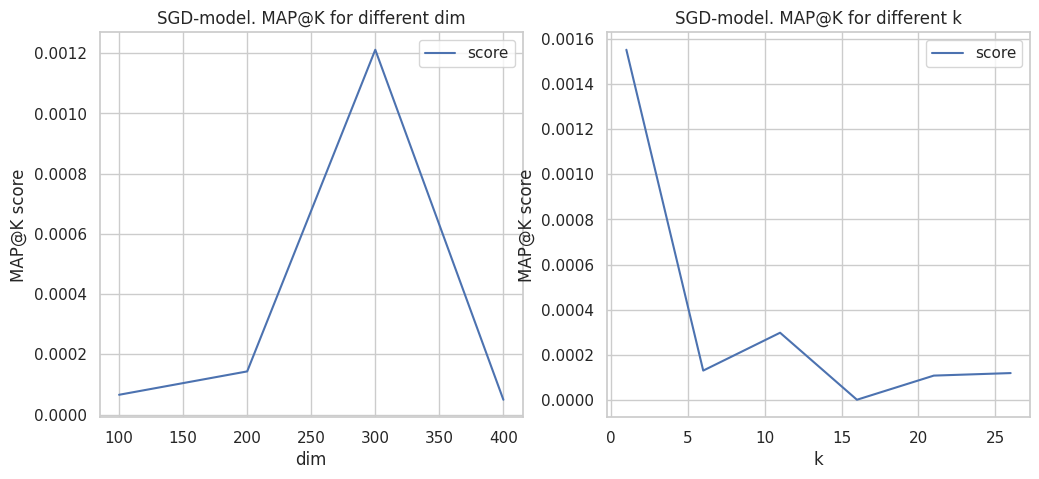

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
info_dim.plot(x='dim', y='score', ax=axs[0], color='b')
info_k.plot(x='k', y='score', ax=axs[1], color='b')

axs[0].set_title("SGD-model. MAP@K for different dim")
axs[0].set_xlabel('dim')
axs[0].set_ylabel('MAP@K score')

axs[1].set_title("SGD-model. MAP@K for different k")
axs[1].set_xlabel('k')
axs[1].set_ylabel('MAP@K score')

## ALS-модель:

In [ ]:
infoals = pd.DataFrame(columns=['dim', 'k', 'score'])

for dim in dims:
    for k in ks:
        model = HiddenVars(train_ratings, dim=dim, mode='als')
        model.fit(num_iters=50)
        recommend = model.get_test_recommendations(k)
        curr_mapk = mapk(test_relevant, recommend, k)

        new_row = {'dim':dim, 'k':k, 'score':curr_mapk}
        infoals = infoals.append(new_row, ignore_index=True)


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-42-61d15cedeec1>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infoals = infoals.append(new_row, ignore_index=True)


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-42-61d15cedeec1>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infoals = infoals.append(new_row, ignore_index=True)


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-42-61d15cedeec1>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infoals = infoals.append(new_row, ignore_index=True)


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-42-61d15cedeec1>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infoals = infoals.append(new_row, ignore_index=True)


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-42-61d15cedeec1>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infoals = infoals.append(new_row, ignore_index=True)


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-42-61d15cedeec1>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infoals = infoals.append(new_row, ignore_index=True)


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-42-61d15cedeec1>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infoals = infoals.append(new_row, ignore_index=True)


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-42-61d15cedeec1>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infoals = infoals.append(new_row, ignore_index=True)


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-42-61d15cedeec1>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infoals = infoals.append(new_row, ignore_index=True)


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-42-61d15cedeec1>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infoals = infoals.append(new_row, ignore_index=True)


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-42-61d15cedeec1>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infoals = infoals.append(new_row, ignore_index=True)


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-42-61d15cedeec1>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infoals = infoals.append(new_row, ignore_index=True)


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-42-61d15cedeec1>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infoals = infoals.append(new_row, ignore_index=True)


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-42-61d15cedeec1>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infoals = infoals.append(new_row, ignore_index=True)


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-42-61d15cedeec1>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infoals = infoals.append(new_row, ignore_index=True)


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-42-61d15cedeec1>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infoals = infoals.append(new_row, ignore_index=True)


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-42-61d15cedeec1>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infoals = infoals.append(new_row, ignore_index=True)


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-42-61d15cedeec1>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infoals = infoals.append(new_row, ignore_index=True)


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-42-61d15cedeec1>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infoals = infoals.append(new_row, ignore_index=True)


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-42-61d15cedeec1>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infoals = infoals.append(new_row, ignore_index=True)


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-42-61d15cedeec1>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infoals = infoals.append(new_row, ignore_index=True)


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-42-61d15cedeec1>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infoals = infoals.append(new_row, ignore_index=True)


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-42-61d15cedeec1>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infoals = infoals.append(new_row, ignore_index=True)


  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-42-61d15cedeec1>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  infoals = infoals.append(new_row, ignore_index=True)


In [ ]:
infoals

,dim,k,score
0,100.0,1.0,0.068323
1,100.0,6.0,0.023723
2,100.0,11.0,0.015094
3,100.0,16.0,0.013189
4,100.0,21.0,0.012573
5,100.0,26.0,0.012923
6,200.0,1.0,0.000000
7,200.0,6.0,0.002070
8,200.0,11.0,0.000648
9,200.0,16.0,0.000775


Построим зависимости качества от гиперпараметров для ALS модели:

In [ ]:
info_dim = infoals.groupby(by='dim').mean()
info_dim = info_dim.reset_index()

info_k = infoals.groupby(by='k').mean()
info_k = info_k.reset_index()

Text(0, 0.5, 'MAP@K score')

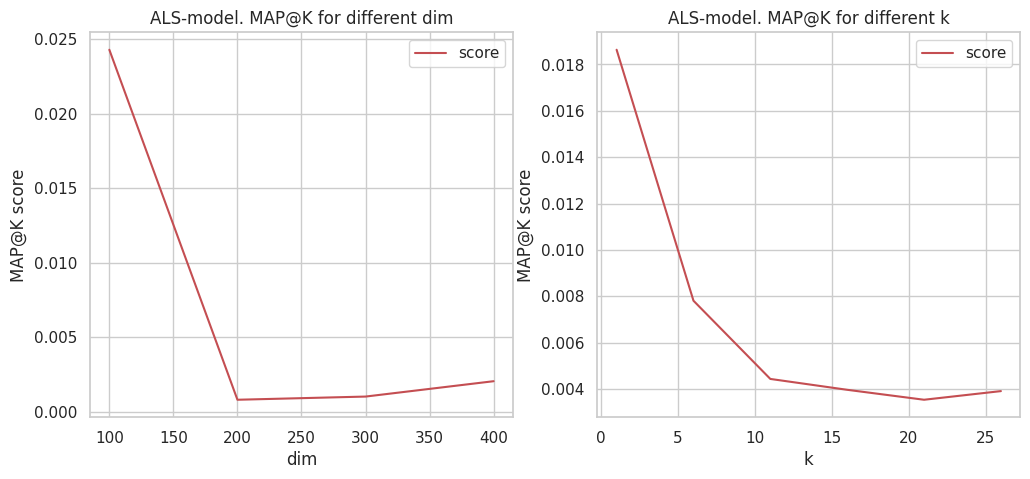

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
info_dim.plot(x='dim', y='score', ax=axs[0], color='r')
info_k.plot(x='k', y='score', ax=axs[1], color='r')

axs[0].set_title("ALS-model. MAP@K for different dim")
axs[0].set_xlabel('dim')
axs[0].set_ylabel('MAP@K score')

axs[1].set_title("ALS-model. MAP@K for different k")
axs[1].set_xlabel('k')
axs[1].set_ylabel('MAP@K score')

Лучшая размерность пространства скрытых переменных для als.

In [ ]:
dim_als = 300

Мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [ ]:
best_model = HiddenVars(train_ratings, dim=dim_als, mode='als')
best_model.fit(num_iters=50)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
train_ratings.user_id.unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163])

In [ ]:
user_id = 115

In [ ]:
books_read = train_ratings[train_ratings.user_id == user_id].book_id[:15]

print('Already read books:')

books.loc[books_read][['name', 'author']]

Already read books:


KeyError: ignored

In [ ]:
preds = best_model.get_test_recommendations(15)

print('Predicted books:')

books.loc[preds[user_id]][['name', 'author']]

In [ ]:
test_books = test_ratings[test_ratings.user_id == user_id].book_id[:15]

print('Test-time books:')

books.loc[test_books][['name', 'author']]

In [ ]:
example_book_id = books[books.name == 'gone too far'].iloc[0].book_id

preds = model.Q @ model.Q[example_book_id]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

book_idxs = preds.argsort()[::-1][:20]

In [ ]:
similar_books = books.loc[book_idxs][['name', 'author']]
similar_books['similarity'] = preds[book_idxs] / np.linalg.norm(model.Q[example_book_id])
similar_books